<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using arterial blood pressure waveform

In this sample code, we will try to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the arterial blood pressure waveform (ART) in the VitalDB dataset.

## Required libraries

In [1]:
!pip install vitaldb
import vitaldb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


## Case Selection

In [2]:
# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) &
    set(df_cases[df_cases['weight'] >= 30]['caseid']) &
    set(df_cases[df_cases['weight'] < 140]['caseid']) &
    set(df_cases[df_cases['height'] >= 135]['caseid']) &
    set(df_cases[df_cases['height'] < 200]['caseid']) &
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) &
    set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) &
    set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])&
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3312 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The arterial waveform data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

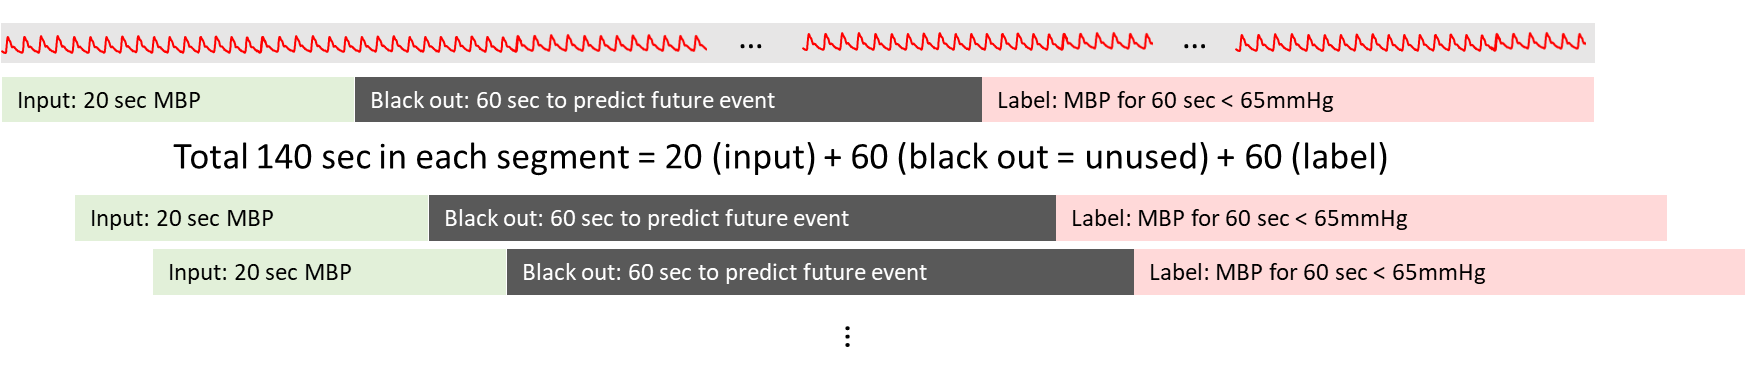

In [3]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 100  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['SNUADC/ART'], 1 / SRATE).flatten()

    case_sample = 0
    case_event = 0
    for i in range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        elif np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 200).any():
            valid = False
        elif (segy > 200).any():
            valid = False
        elif (segx < 30).any():
            valid = False
        elif (segy < 30).any():
            valid = False
        elif np.max(segx) - np.min(segx) < 30:
            valid = False
        elif np.max(segy) - np.min(segy) < 30:
            valid = False
        elif (np.abs(np.diff(segx)) > 30).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 30).any():  # abrupt change -> noise
            valid = False

        # 2 sec moving avg
        n = 2 * SRATE
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)

        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100 * case_event / case_sample))
    else:
        print('no sample')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

# convert lists to numpy array
x = np.array(x)
y = np.array(y)
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

# add axis for CNN
x = x[...,None]

print(x.shape)
print(y.shape)

loading 293...772 samples 27 (3.5 %) events
loading 697...1268 samples 47 (3.7 %) events
loading 3001...705 samples 28 (4.0 %) events
loading 1081...1653 samples 41 (2.5 %) events
loading 1143...496 samples 36 (7.3 %) events
loading 957...1375 samples 5 (0.4 %) events
loading 2321...951 samples 97 (10.2 %) events
loading 5638...1401 samples 34 (2.4 %) events
loading 3136...458 samples 12 (2.6 %) events
loading 2698...750 samples 20 (2.7 %) events
loading 3594...2488 samples 0 (0.0 %) events
loading 5746...1790 samples 217 (12.1 %) events
loading 1623...340 samples 7 (2.1 %) events
loading 4904...506 samples 0 (0.0 %) events
loading 1096...1233 samples 24 (1.9 %) events
loading 3436...723 samples 10 (1.4 %) events
loading 3538...342 samples 0 (0.0 %) events
loading 1864...172 samples 0 (0.0 %) events
loading 130...1302 samples 0 (0.0 %) events
loading 3499...1633 samples 0 (0.0 %) events
loading 447...924 samples 0 (0.0 %) events
loading 4226...3873 samples 7 (0.2 %) events
loading 5534

/tmp/ipython-input-3-2623668723.py:83: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


(142181, 2000, 1)
(142181,)


## Splitting samples into training and testing dataset


In [4]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# splitting into train set and test set
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), \
    len(train_y_valid), sum(train_y_valid), 100 * np.mean(train_y_valid), \
    len(test_y_valid), sum(test_y_valid), 100 * np.mean(test_y_valid))
print(testname)

100cases 1ahead batchsize=256 total 142181, train 83762 (1833 events 2.2%), test 22846 (389 events 1.7%)


## Model building and training

In [5]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.keras"

# hyper parameter
CNN_LAYERS = [64] * 6

# build a model
model = Sequential()
for num_node in CNN_LAYERS:
    model.add(Conv1D(filters=num_node, kernel_size=3, padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9553 - auc: 0.9501 - loss: 0.1802
Epoch 1: val_loss improved from inf to 0.01077, saving model to output/weights.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 85s 239ms/step - accuracy: 0.9553 - auc: 0.9501 - loss: 0.1801 - val_accuracy: 0.9971 - val_auc: 0.9990 - val_loss: 0.0108
Epoch 2/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9627 - auc: 0.9675 - loss: 0.1514
Epoch 2: val_loss did not improve from 0.01077
295/295 ━━━━━━━━━━━━━━━━━━━━ 63s 213ms/step - accuracy: 0.9627 - auc: 0.9675 - loss: 0.1514 - val_accuracy: 0.9950 - val_auc: 0.9993 - val_loss: 0.0165
Epoch 3/100
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9624 - auc: 0.9674 - loss: 0.1470
Epoch 3: val_loss did not improve from 0.01077
295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 212ms/step - accuracy: 0.9624 - auc: 0.9674 - loss: 0.1470 - val_accuracy: 0.9877 - val_auc: 0.9992 - val_loss: 0.0267


16712

## Evaluation of the model performance

In [6]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_p = model.predict(test_x, BATCH_SIZE).flatten()
test_p_valid = test_p[valid_mask[test_mask]]

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_p_valid)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_p_valid)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_p_valid > thval)
acc = accuracy_score(test_y_valid, test_p_valid > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_p_valid > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
auroc=0.972, auprc=0.330 acc=0.983, F1=0.000, PPV=nan, NPV=98.3, TN=22457, fp=0, fn=389, TP=0


/tmp/ipython-input-6-3617432106.py:18: RuntimeWarning: invalid value encountered in scalar divide
  testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)


## Plotting each case in the test dataset

5475	0.0054916152730584145	


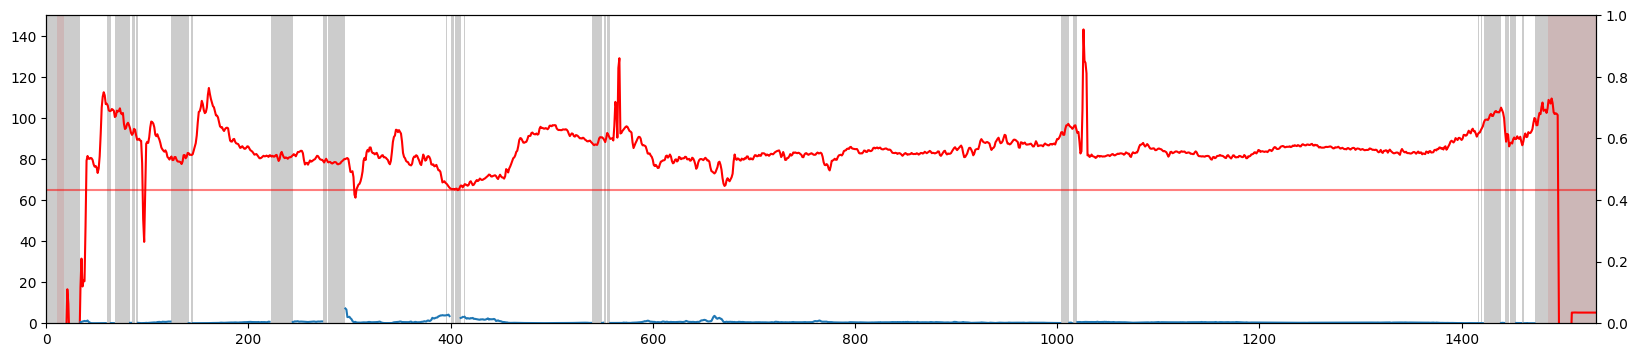

5531	0.005249586887657642	


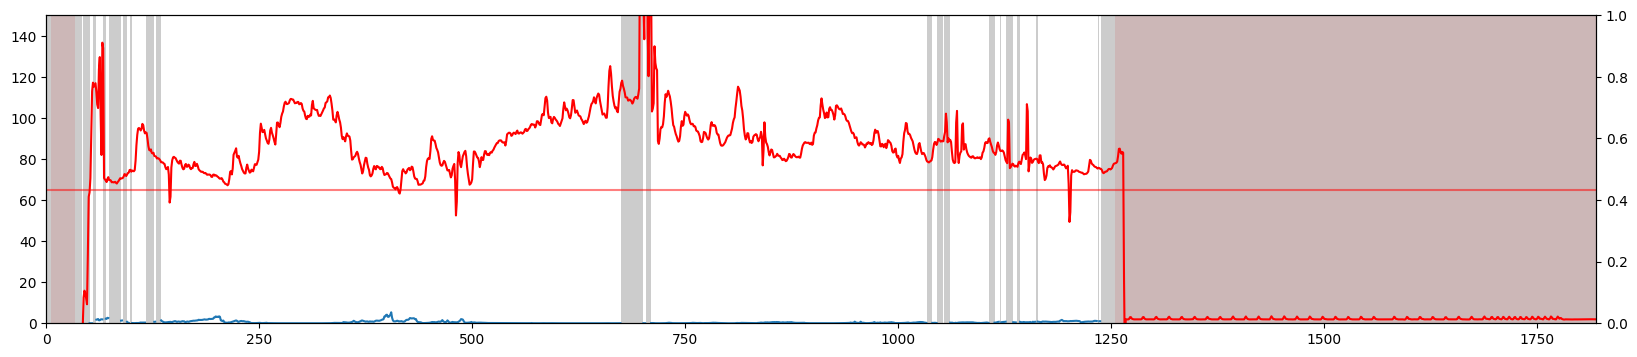

5534	0.044599901884794235	


/tmp/ipython-input-7-552489927.py:34: RuntimeWarning: Mean of empty slice
  ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')


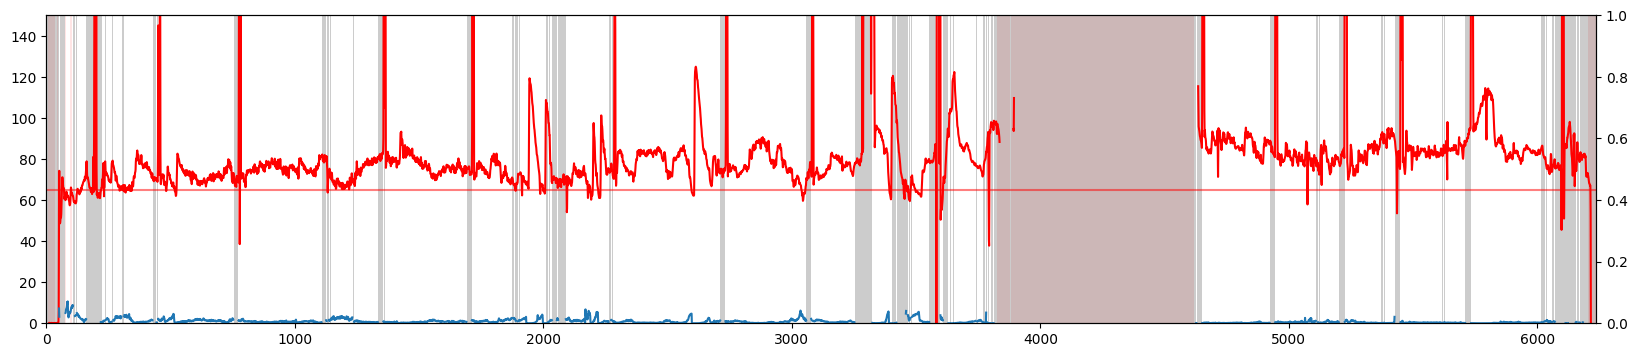

5544	0.0019638340454548597	


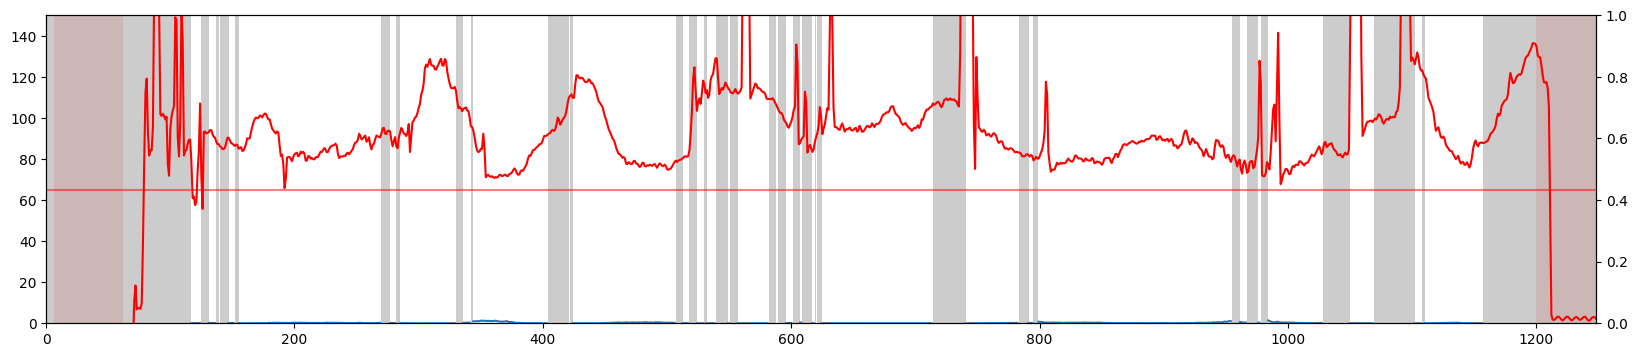

5572	0.08012474328279495	


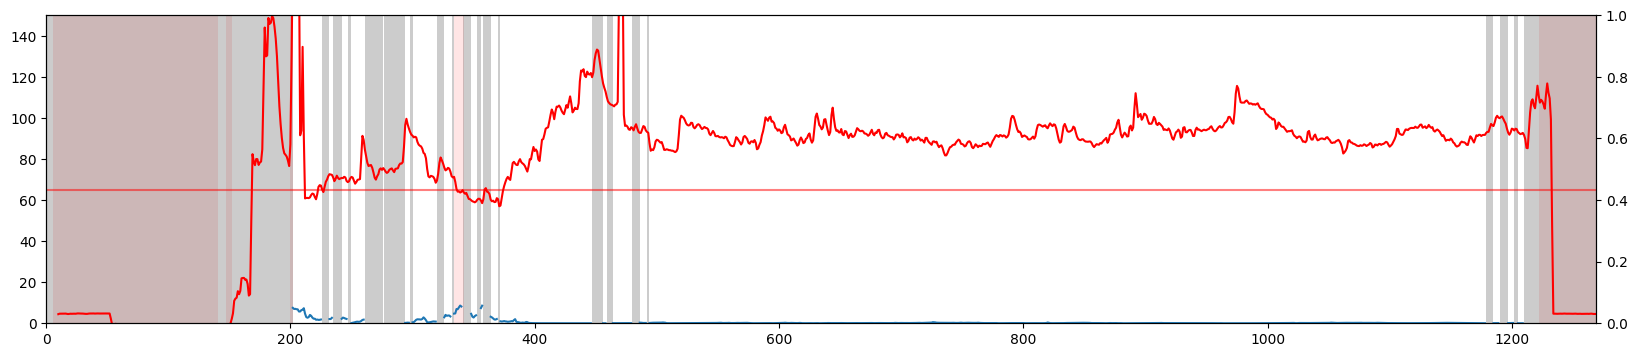

5638	0.15150855481624603	


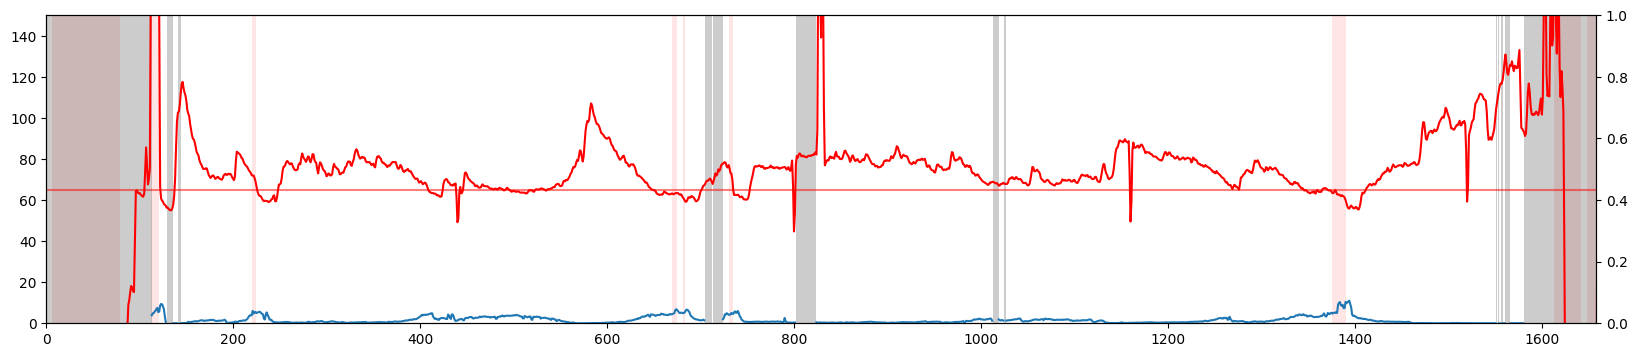

5745	0.01247971598058939	


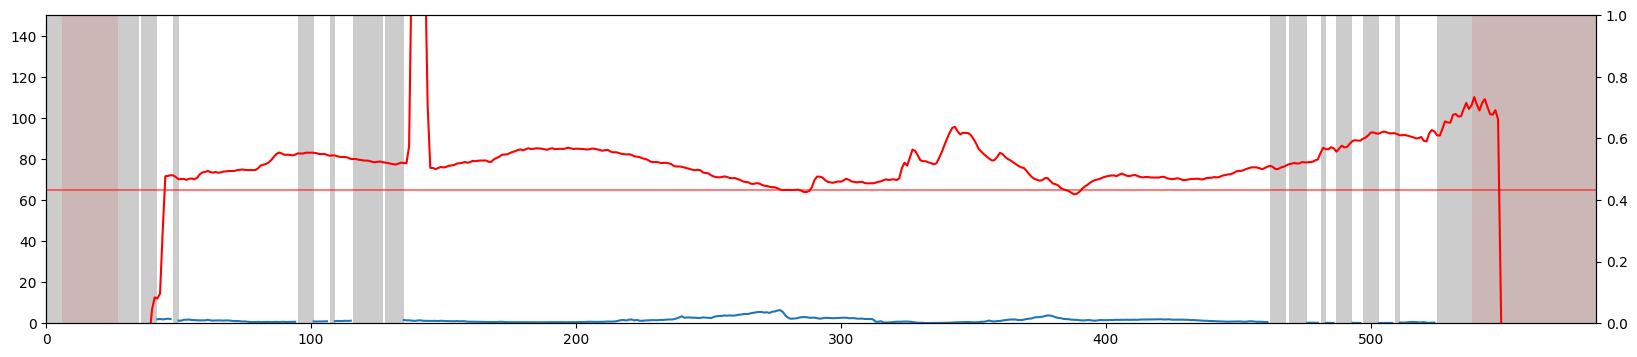

5746	0.33005407452583313	


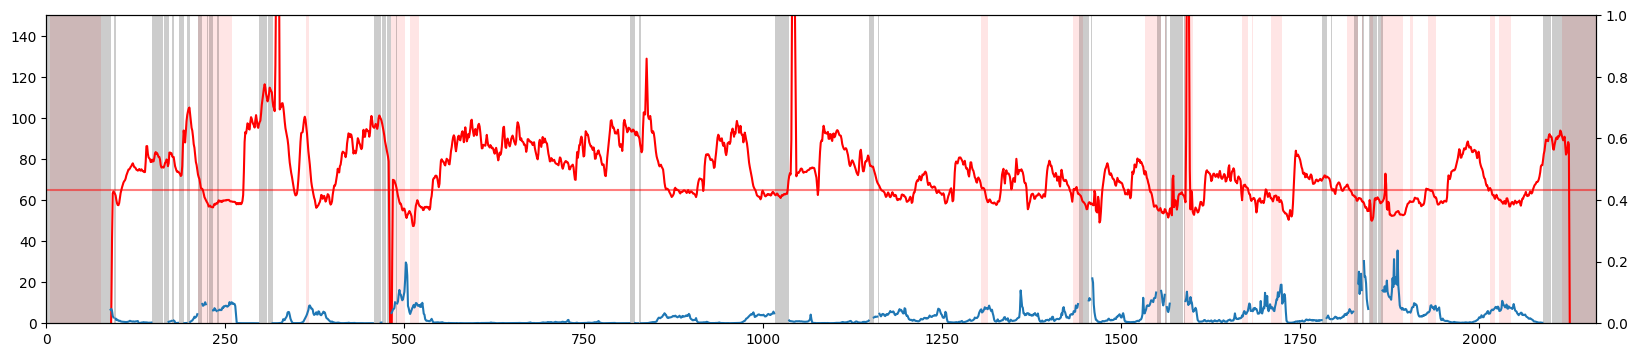

5799	0.006275263149291277	


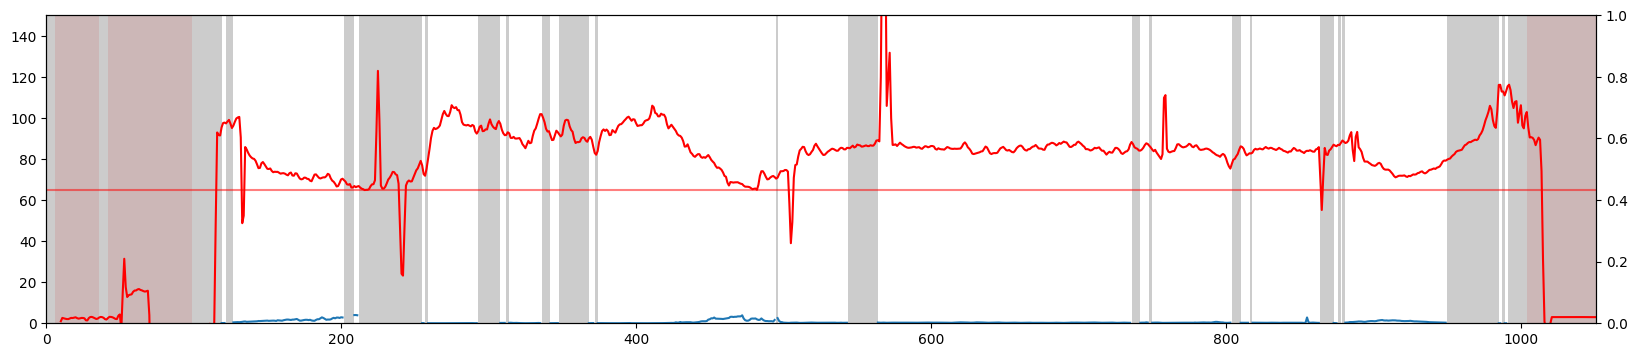

5908	0.40384846925735474	


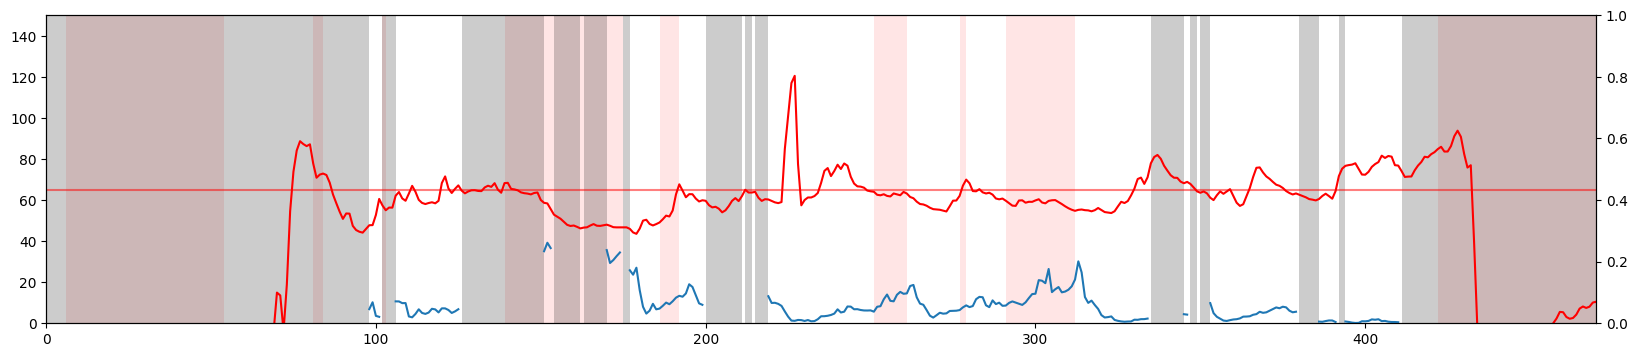

5928	0.04946271330118179	


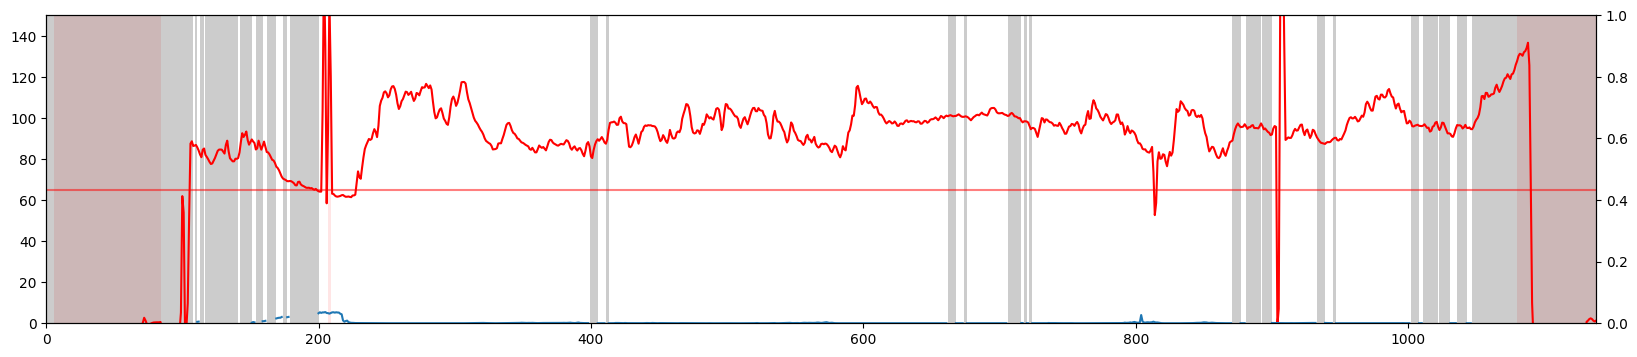

5945	0.013983477838337421	


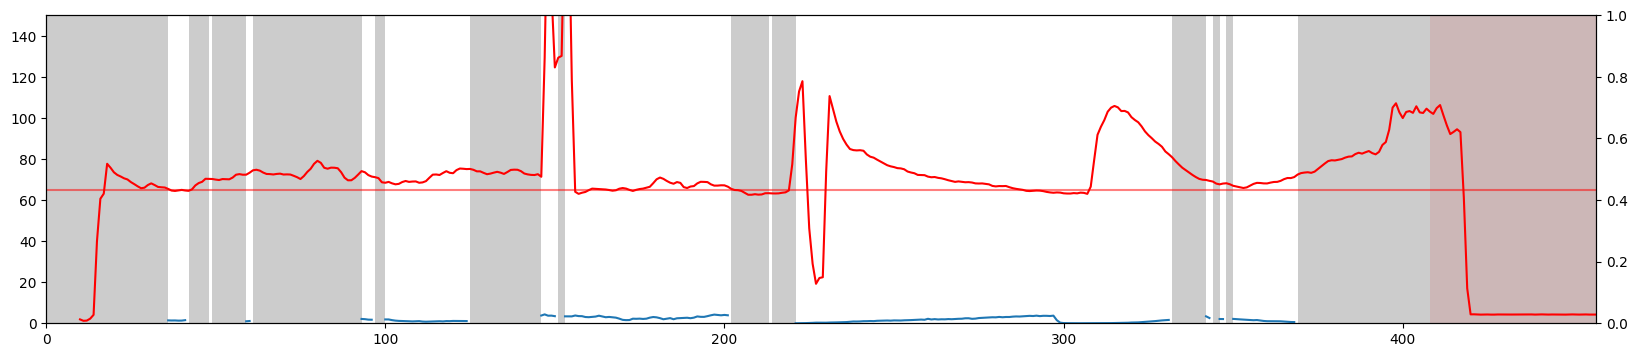

5950	0.1508598029613495	


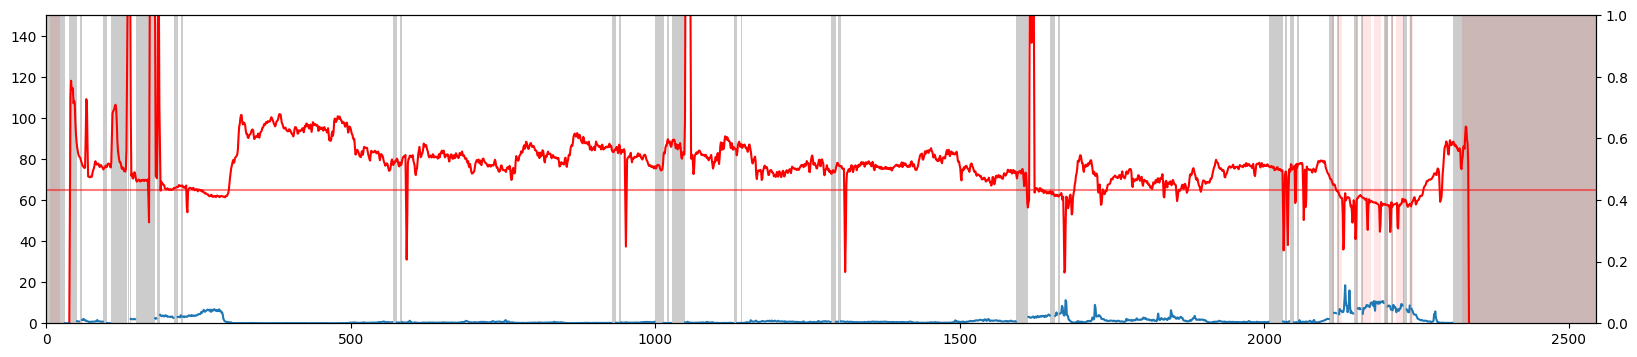

6039	0.007943841628730297	


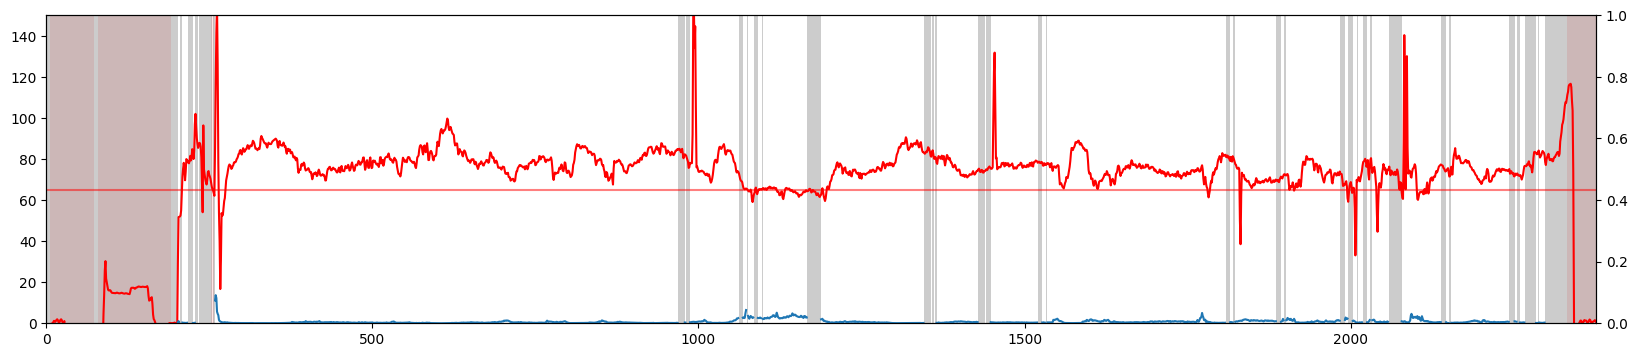

6074	0.06652610749006271	


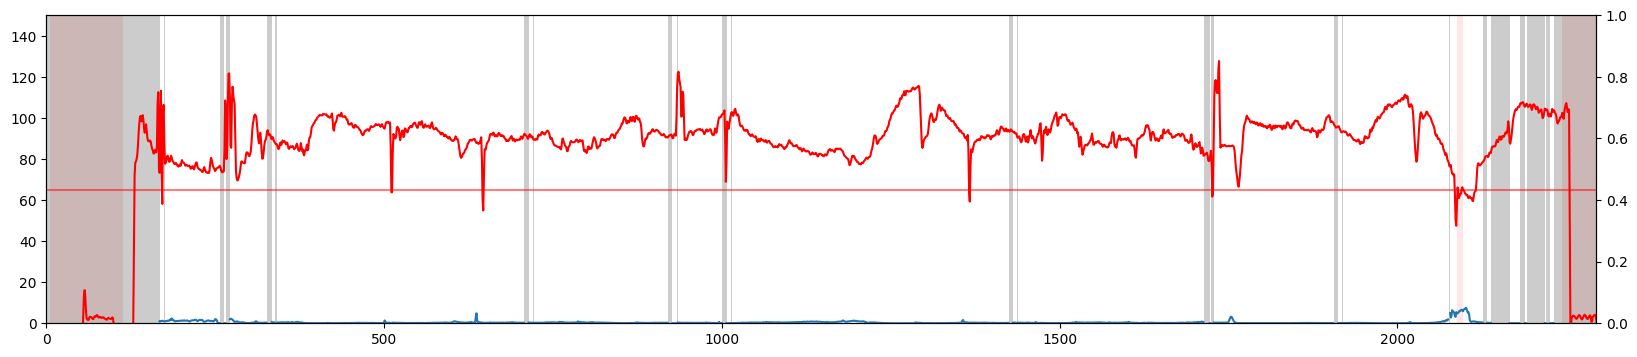

6171	0.00515622878447175	


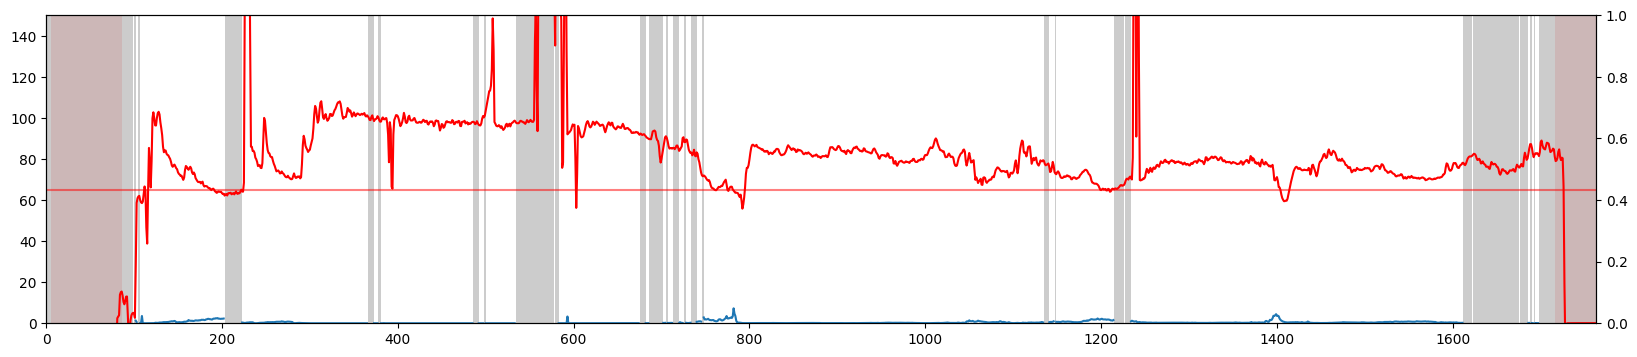

6206	0.14616894721984863	


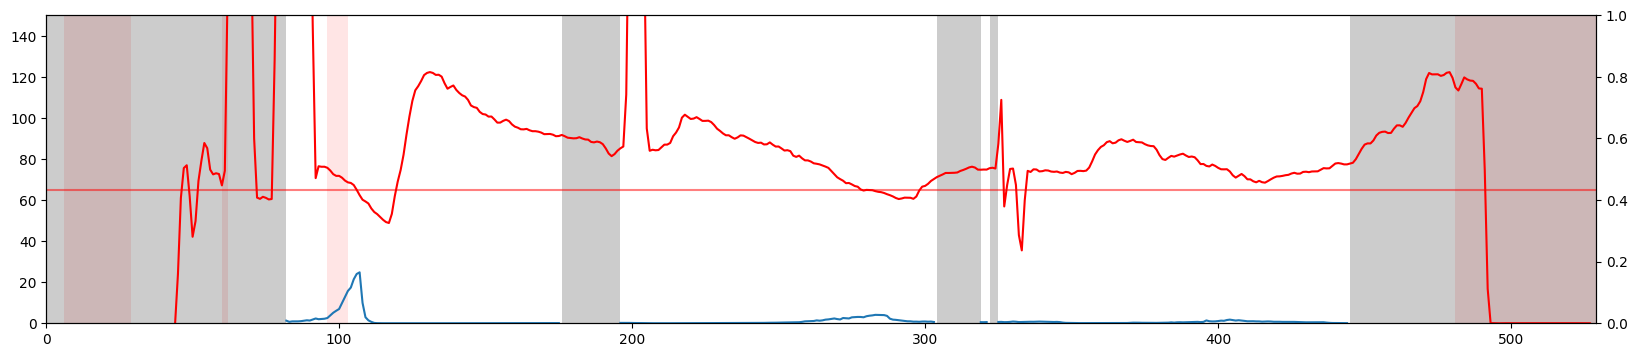

6339	0.09305968880653381	


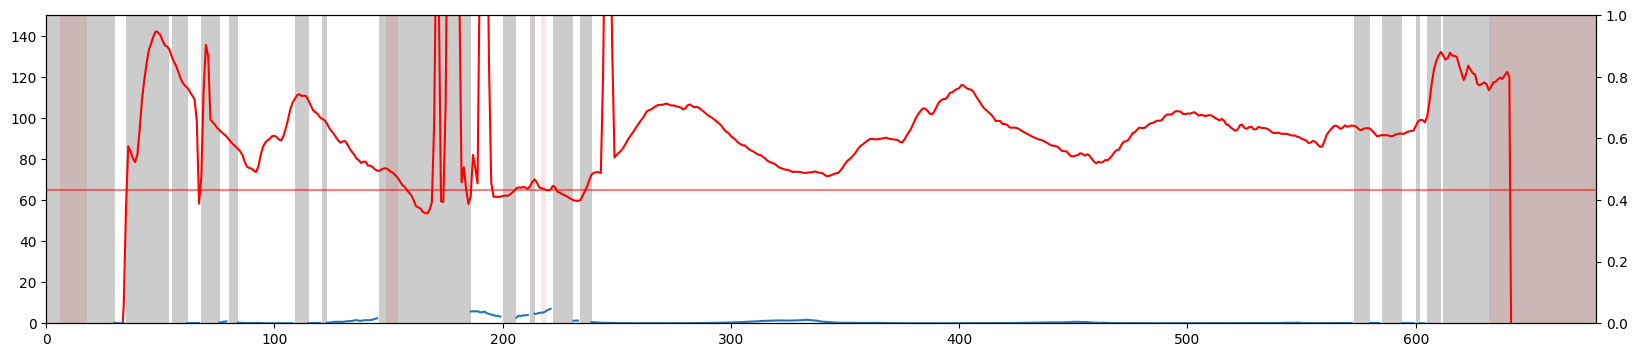

6376	0.08859287202358246	


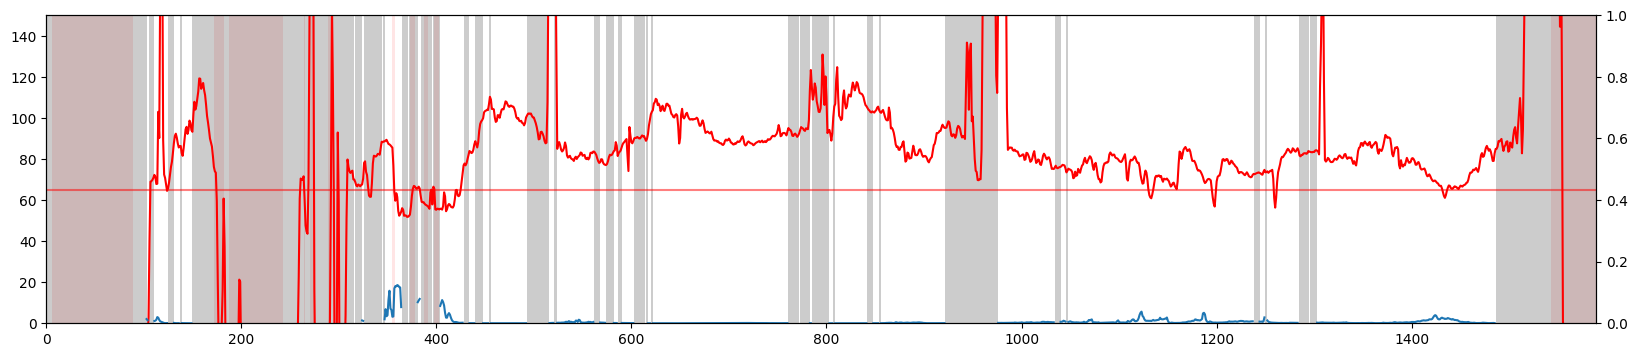

In [7]:
for caseid in caseids_test:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = test_x[case_mask]
    case_y = test_y[case_mask]
    case_p = test_p[case_mask]
    case_valid_mask = valid_mask[test_mask][case_mask]
    case_p[~case_valid_mask] = np.nan
    if sum(case_valid_mask) == 0:
        continue

    # calculate error for this case
    case_rmse = np.nanmean(np.square(case_y - case_p)) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 6, i + MINUTES_AHEAD * 6 + 1, color='r', alpha=0.1, lw=0)
        if not case_valid_mask[i]:
            ax1.axvspan(i, i + 1, color='k', alpha=0.2, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()

    # draw valid samples only
    ax2.plot(t, case_p)
    ax2.set_ylim([0, 1])

    # save
    plt.show()